In [664]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import statistics as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.distributions.empirical_distribution import ECDF
from TimeSerie_fct import create_monthly_avg_time_serie
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
import os



data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))

data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.

In [665]:
df = data_temperature.copy()

In [666]:
#Division of the data into 7 periods of 20 years
df["period"] = [(y-1901)//20+1 for y in df.Year]
#df["period"] = [(y-1901)+1 for y in df.Year]
df.loc[df.period == 13,"period"] = 12
df["global_index"] =np.arange(0,np.shape(df.TG)[0])

# Regression with ARMA Errors

## Linear regression for the trend and seasonality

In [667]:
df["Seasonless_TG"] = np.zeros(shape = (np.shape(df.TG)[0],))
coef_lin_reg = np.zeros(shape=(6,4))
mean_med = np.zeros(shape=(6,3))

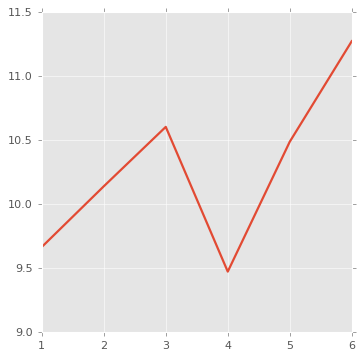

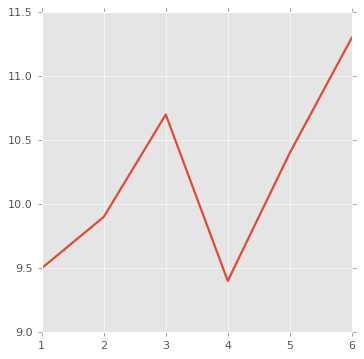

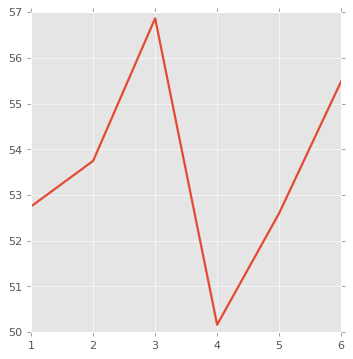

In [668]:
for p in range(1,7):
    mean = df[df.period==p].TG.mean()
    med = df[df.period==p].TG.median()
    var = df[df.period==p].TG.var()
    
    n = np.shape(df[df.period==p].TG)[0]
    t = np.linspace(0,n-1,n).reshape((n,1))
    one = np.ones(shape=(np.shape(t)[0],1))
    X = np.concatenate([one,t,np.cos(2*np.pi*t/365.),np.sin(2*np.pi*t/365.)],axis = 1)
    
    mean_med[p-1] = np.array([mean,med,var])
    
    linear_regression = LinearRegression(fit_intercept = True).fit(X,df[df.period==p].TG)
    coef_lin_reg[p-1] = linear_regression.coef_

    f = lambda x: coef_lin_reg[p-1,0]+coef_lin_reg[p-1,1]*x+coef_lin_reg[p-1,2]*np.cos(2*np.pi*x/365.)+coef_lin_reg[p-1,3]*np.sin(2*np.pi*x/365.)
    s = f(t)
    
    df.loc[df.period == p,"Seasonless_TG"] = df[df.period==p].TG-mean-s.reshape((np.shape(s)[0],))

plt.figure(figsize = (5,5))
plt.plot(range(1,7),mean_med[:,0])
plt.figure(figsize = (5,5))
plt.plot(range(1,7),mean_med[:,1])
plt.figure(figsize = (5,5))
plt.plot(range(1,7),mean_med[:,2])


# Model selection for the ARMA Error

We use AIC and BIC in order to select the best model for the deseasonalized time serie. We restrict the values of the parameters p and q to a certain interval so as not to obtain too complicated models.

In [669]:
p = np.array(np.arange(0,4))
q = np.array(np.arange(0,4))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))
BIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC,BIC]).T, columns = ["param_p","param_q","AIC","BIC"])

In [670]:
periode = 6
for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(df[df.period==periode].Seasonless_TG, order=(pp,0,qq),enforce_stationarity = True, enforce_invertibility = True).fit()
    model_selection.AIC[i] = arma_mod.aic
    model_selection.BIC[i] = arma_mod.bic

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/

In [499]:
i = np.argmin(model_selection.AIC)
j = np.argmin(model_selection.BIC)
print(j)
model_selection

12


,param_p,param_q,AIC,BIC
0,0.0,0.0,37795.337011,37809.129640
1,0.0,1.0,32686.403113,32707.092056
2,0.0,2.0,31077.303811,31104.889069
3,0.0,3.0,30527.853811,30562.335383
4,1.0,0.0,30300.756322,30321.445264
5,1.0,1.0,30058.059500,30085.644758
6,1.0,2.0,30053.882083,30088.363655
7,1.0,3.0,30046.621368,30087.999254
8,2.0,0.0,30090.770034,30118.355291
9,2.0,1.0,30055.684915,30090.166487


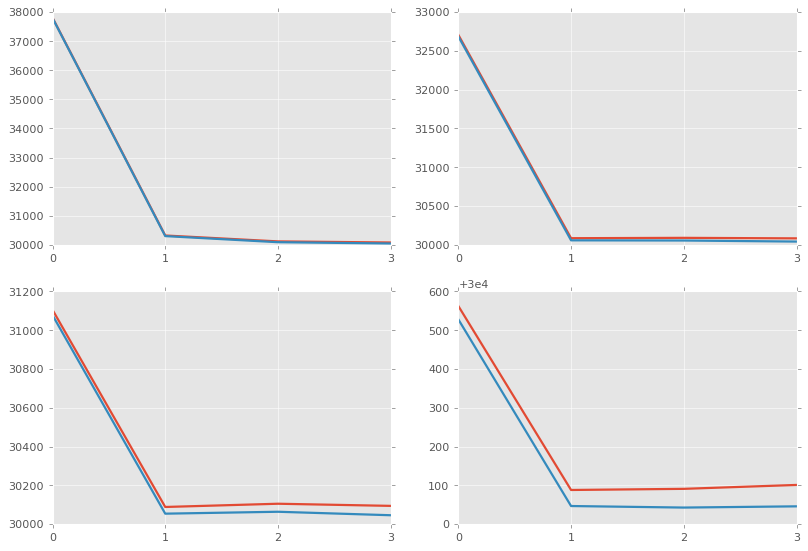

In [500]:
fig = plt.figure(figsize=(12,8))
plt.style.use("ggplot")
for i in range(4):
    fig.add_subplot(2,2,i+1)
    axes = plt.gca()
    axes.xaxis.set_ticks(range(4))
    #axes.xaxis.set_ticklabels(['0', '1', 'p = 2', 'p = 3'], rotation = 0, color = 'black', fontsize = 10, verticalalignment = 'center')
    plt.plot(np.arange(0,4),model_selection[model_selection.param_q==i].BIC)
    plt.plot(np.arange(0,4),model_selection[model_selection.param_q==i].AIC)
    # Pour ajouter du texte
    #plt.text(s=plt.style.available[i], x=5, y=2, color='red')

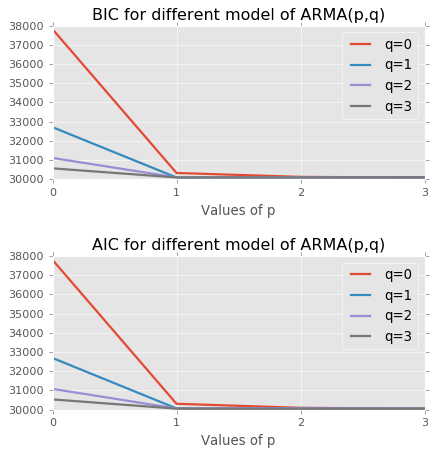

In [501]:

fig = plt.figure(figsize=(6,6))
plt.gcf().subplots_adjust( hspace = 0.5)
plt.subplot(211)
plt.title("BIC for different model of ARMA(p,q)")
plt_table = list()
for i in range(4):
    axes = plt.gca()
    axes.xaxis.set_ticks(range(4))
    plt_table.extend(plt.plot(np.arange(0,4),model_selection[model_selection.param_q==i].BIC))
plt.xlabel("Values of p")
plt.legend(plt_table,["q=0","q=1","q=2","q=3"])
plt.subplot(212)
plt.title("AIC for different model of ARMA(p,q)")
for i in range(4):
    axes = plt.gca()
    axes.xaxis.set_ticks(range(4))
    plt_table.extend(plt.plot(np.arange(0,4),model_selection[model_selection.param_q==i].AIC))
plt.xlabel("Values of p")
plt.legend(plt_table,["q=0","q=1","q=2","q=3"])

Comme on peut le voir sur les graphes ci-dessus, les valueurs de l'AIC et du BIC stagne rapidement vers une valeur respective fixe et cela même si on complexifie le modèle en augmentant $p$ et/ou $q$. Suivant le principe du rasoir d'Ockham, nous aurions donc tendance à choisir le modèle le plus simple qui fournit des résultats semblablent aux modèles plus complexes, cela réduirait aussi grandement la quantité de calculs à effectuer.  

Dans la suite, nous considèrerons donc le modèle ARMA(1,1).

In [623]:
p=3
q=2
periode = 6
new_index = np.arange(0,np.shape(df[df.period == periode].TG)[0])
df1=df[df.period == periode].copy().set_index(new_index)

arma_mod = ARIMA(df1.Seasonless_TG, order=(p,0,q),enforce_stationarity = True, enforce_invertibility = True).fit()

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


1475.5170753349125


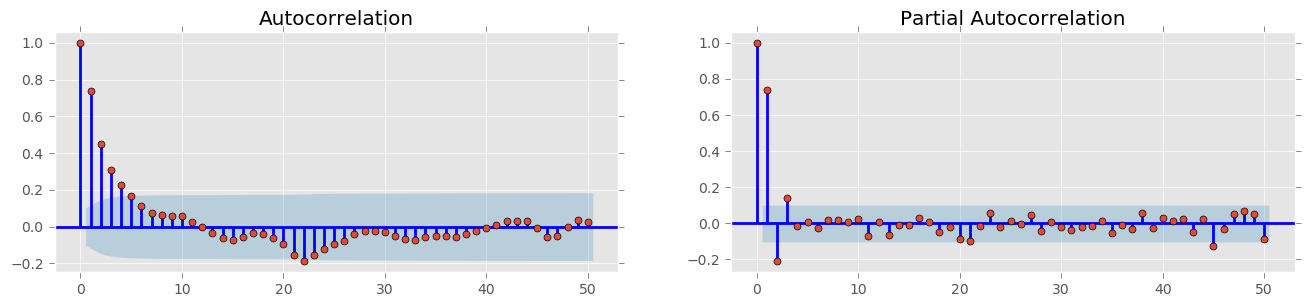

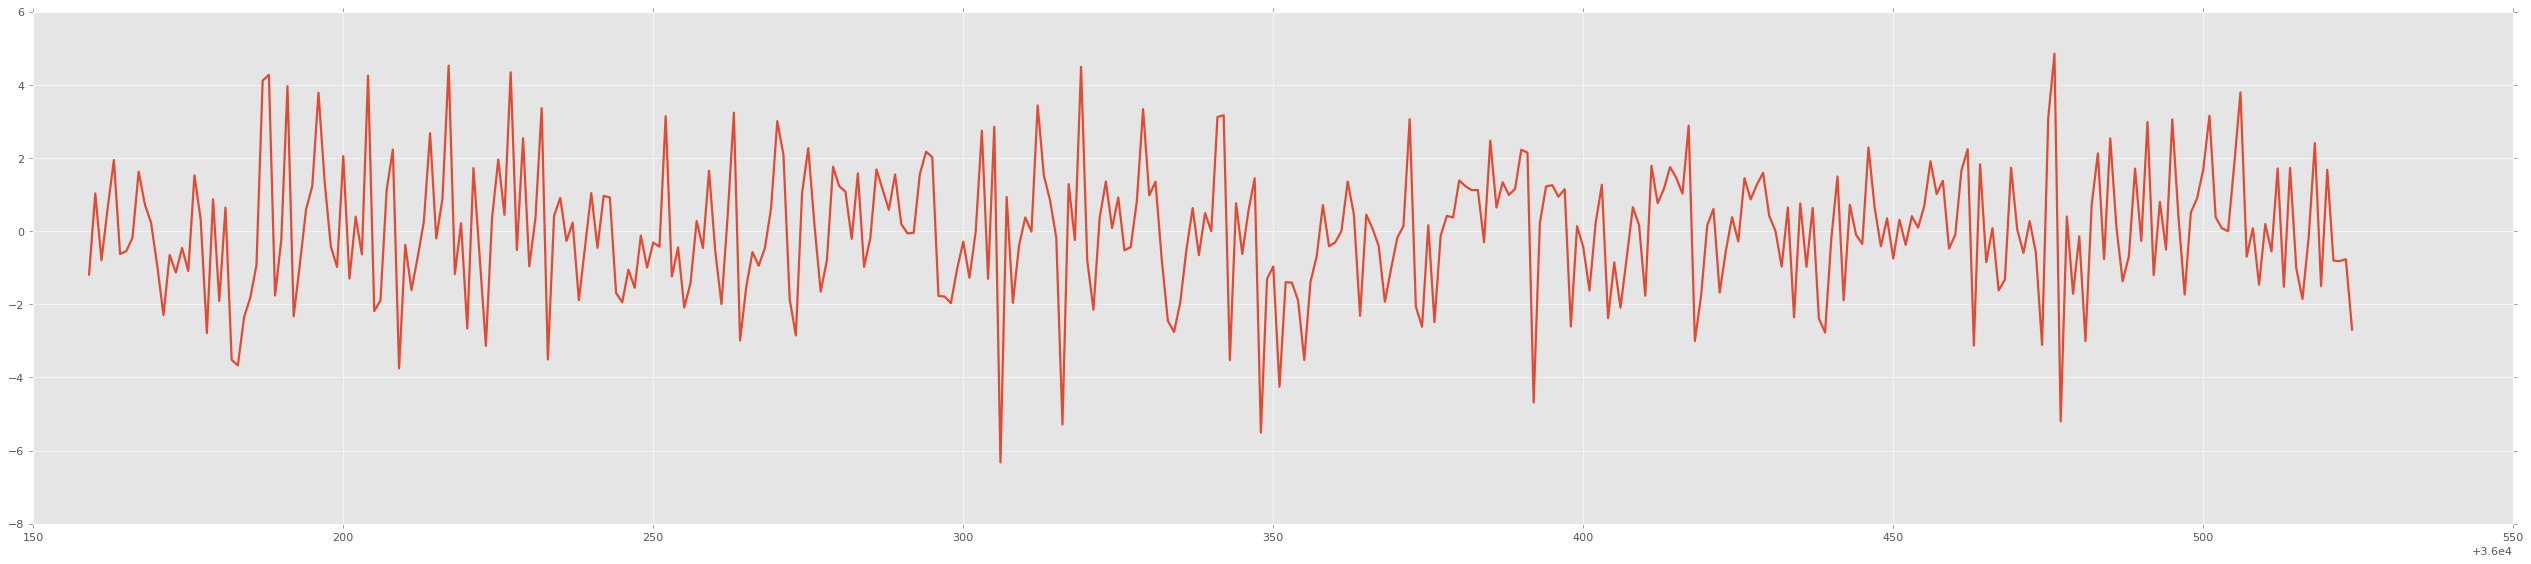

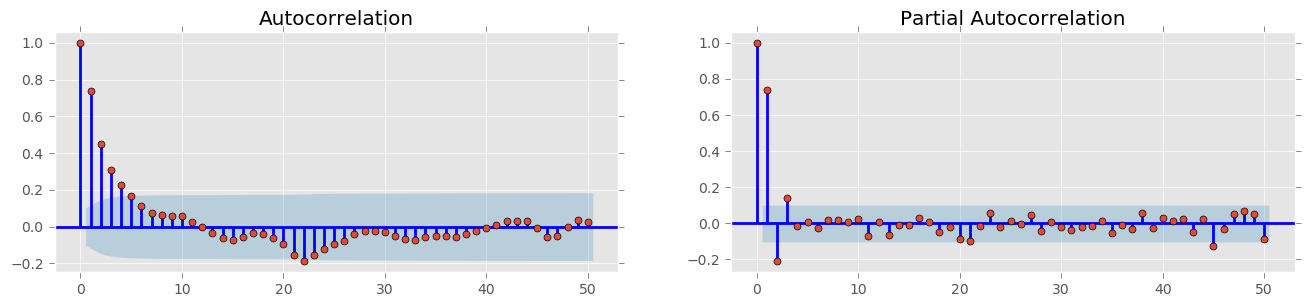

In [624]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(40,8))
plt.plot(arma_mod.resid)
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
print(arma_mod.aic)
plot_acf(df1.Seasonless_TG, lags=50, ax=axes[0])
plot_pacf(df1.Seasonless_TG, lags=50, ax=axes[1])

In [625]:
sm.stats.acorr_ljungbox(arma_mod.resid, lags=range(p+q+1,50+p+q+1), return_df=True, model_df = p+q)

,lb_stat,lb_pvalue
6,0.091781,0.761925
7,0.448692,0.799039
8,0.638060,0.887667
9,0.778032,0.941369
10,2.878611,0.718694
11,3.105186,0.795534
12,3.312304,0.854688
13,3.657733,0.886609
14,3.926330,0.916194
15,4.503269,0.921802
